The notebook aims to test the ability of neural network to esimate probabilities when probabilities are low and when samples are not evenly distributed.  In other word when many requests come from cities.

# Key open questions  
0. Does it matter if world_size is 1 or 100?  Aka do I need to preprocess
1. Does downsmapling help with p fit?
2. Does downsampling bias results? Can they be un-biased?
3. Do deeper or wider networks help?
4. Do SELUs help?
5. Do gaussian blob regularized to prevent small blobs, yield better fits?
6. Which batch sizes work best?
7. What is best way to prevent overfitting?
8. Does it help to gradually reduce learning rate... create new optimizer ever N epochs 

TODO: 
1. fix prob map generation: cluster_peaks is not parameterized well.
2. Save movie of fitting at finer scale then 1 epoch


# generate data  

Their are only two features, x and y, which represent location.  

The are two maps associated with x,y location.

The first is the probabiilty of a request being generated a position x,y. 

The second is the probabilty of a conversion occuring a position x,y.

There are 4 classes generating request locations.  We define the probability that a request comes from each class.  Then each class is 2d gaussian blob, except the last class, which is uniform.

The binomial probability of converting at each location is a map formed by summing several multivariate gaussian blobs with distinct locations and shapes from the request generating blobs.


In [2]:
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline
# matplotlib notebook is better, but not in Jupyter Lab

from __future__ import absolute_import, division, print_function

import os
import tensorflow as tf
import tensorflow.contrib.eager as tfe

tf.enable_eager_execution()

print("TensorFlow version: {}".format(tf.VERSION))
print("Eager execution: {}".format(tf.executing_eagerly()))

Set parameters for generating data

In [3]:
#Define parameters of generated data
world_size = (100,100)
num_requests = 1000000

#Define request distrubiton
city_dist = [.2,.15,.1,.5,.05] #city 1, 2, 3, 4, uniform
city_locations = [(20,20), (70,50), (30,80), [30,50]]
city_covariance = [[[25,0],[0,25]],
                   [[20,-15],[-15,20]],
                   [[5,3],[3,5]],
                   [[200,0],[0,400]]]

#Define conversion probabillity
convert_baseline = .00001
#cluster_prob = [.005,.02,.01,.001,.04]
#cluster_prob = [.5,.3,1,.05,.7]
cluster_prob = [20,20,20,20,20]
cluster_loc = [(20,25), (65,55), (10,60), (20,15), (85,10)]
cluster_cov = [[[10,0],[0,20]],
               [[20,15],[15,20]],
               [[10,0],[0,10]],
               [[4,0],[0,4]],
               [[4,2],[2,4]]]

In [51]:
#Define parameters of generated data
world_size = (1,1)
num_requests = 1000000

#Define request distrubiton
city_dist = [.2,.15,.1,.5,.05] #city 1, 2, 3, 4, uniform
city_locations = [(.20,.20), (.70,.50), (.30,.80), (.30,.50)]
city_covariance = [[[.025,0],[0,.025]],
                   [[.020,-.015],[-.015,.020]],
                   [[.005,.003],[.003,.005]],
                   [[2.00,0],[0,4.00]]]
                   
#Define conversion probabillity
convert_baseline = .00001
#cluster_prob = [.005,.02,.01,.001,.04]
#cluster_prob = [.5,.3,1,.05,.7]
#cluster_prob = [.005,.005,.005,.005,.007]
cluster_prob = [.0005,.0003,.001,.00005,.005]
cluster_loc = [(.20,.25), (.65,.55), (.10,.60), (.20,.15), (.85,.10)]
cluster_cov = [[[.0010,0],[0,.0020]],
               [[.0020,.0015],[.0015,.0020]],
               [[.0010,0],[0,.0010]],
               [[.004,0],[0,.004]],
               [[.004,.002],[.002,.004]]]

Generate request locations

In [53]:
#get counts from each city
city_counts = np.random.multinomial(num_requests, city_dist)

requests = []
for n_city in range(len(city_counts)):
    if n_city < len(city_dist)-1:
        r = np.random.multivariate_normal(city_locations[n_city], 
                                          city_covariance[n_city],
                                          city_counts[n_city])
    else:
        r = np.random.random([city_counts[n_city],2]) * world_size
    requests.append(r)
requests = np.vstack(requests)
requests = requests[(requests[:,0]>0) & (requests[:,0]<world_size[0]),:]
requests = requests[(requests[:,1]>0) & (requests[:,1]<world_size[1]),:]
np.random.shuffle(requests)

Plot histogram of request locations

/home/ubuntu/anaconda3/envs/tensorflow_p36/lib/python3.6/site-packages/matplotlib/axes/_axes.py:6462: UserWarning: The 'normed' kwarg is deprecated, and has been replaced by the 'density' kwarg.
  warnings.warn("The 'normed' kwarg is deprecated, and has been "


(0, 1)

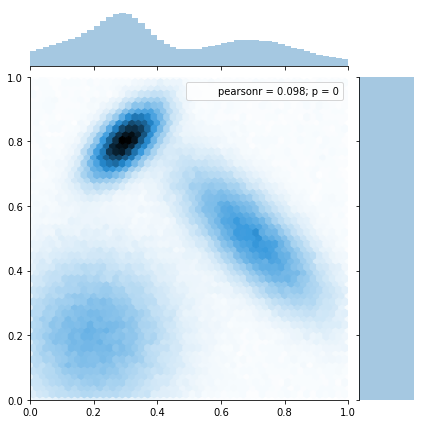

In [54]:
sns.jointplot(x=requests[:,0], y=requests[:,1], kind="hex");
plt.xlim(0,world_size[0])
plt.ylim(0,world_size[1])

Visualize probablity of conversion map by sampling on grid  
`grid` is the set of points to be sampled (will be used later)


(0, 1)

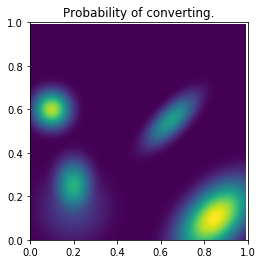

In [55]:
from scipy.stats import multivariate_normal

#visualize the probability map
x, y = np.mgrid[0:world_size[0]:world_size[0]/100, 0:world_size[1]:world_size[1]/100]
grid = np.dstack((x, y))
p_grid = np.ones(grid.shape[0:2])*convert_baseline
for nc in range(len(cluster_prob)):
    p_grid += cluster_prob[nc] * multivariate_normal.pdf(grid, mean=cluster_loc[nc], cov=cluster_cov[nc])
fig2 = plt.figure()
ax2 = fig2.add_subplot(111)
ax2.set_aspect(1)
ax2.contourf(x, y, np.power(p_grid,.3), 256) #altered gamma so faint blobs visible
ax2.set_title('Probability of converting.')
plt.xlim(0,world_size[0])
plt.ylim(0,world_size[1])

Flip coin for each request to determine if it converted.  
`p_request` is the probability each request converted.  
`b_convert` is the result of the coin flips (the labels)

Num conversions: 1813
Coversion prob max: 0.22969847678818797 avg: 0.0036790153329411463


(0, 1)

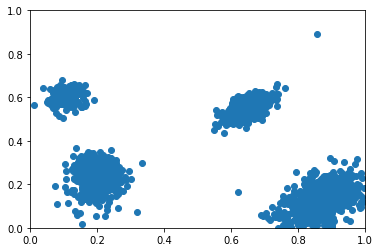

In [56]:
p_requests = np.ones(requests.shape[0])*convert_baseline
for nc in range(len(cluster_prob)):
    p_requests += cluster_prob[nc] * multivariate_normal.pdf(requests, mean=cluster_loc[nc], cov=cluster_cov[nc])
b_convert = np.random.random(requests.shape[0])<p_requests

print('Num conversions:', b_convert.sum())
print('Coversion prob max:', p_requests.max(), 'avg:', p_requests.mean())
plt.scatter(requests[b_convert,0],requests[b_convert,1])
plt.xlim(0,world_size[0])
plt.ylim(0,world_size[1])

Split into train and test

In [57]:
split = np.floor(len(requests)*9/10).astype(int)
X_train, X_test = requests[:split].astype('single'), requests[split:].astype('single')
y_train, y_test = b_convert[:split].astype('int32'), b_convert[split:].astype('int32')
y_train = np.expand_dims(y_train,1)
y_test = np.expand_dims(y_test,1)
p_train, p_test = p_requests[:split], p_requests[split:]
print('done')

done


# Try Tensor Flow

Convert data to tensorflow datasets

In [60]:
batch_size=1024

def get_tf_dataset(X, y, batch_size, bShuffle=True):
    dataset = tf.data.Dataset.from_tensor_slices((X,y))
    if bShuffle:
        dataset = dataset.shuffle(20000)
    #dataset = dataset.repeat() - prevents epoch loops
    dataset = dataset.batch(batch_size)
    return dataset
    
train_dataset = get_tf_dataset(X_train,y_train,batch_size)
test_dataset = get_tf_dataset(X_test,y_test,batch_size)
    
# View a single example entry from a batch and check shapes
features, label = tfe.Iterator(train_dataset).next()
print("example features:", features[0])
print("example label:", label[0])
print("features shape and type:", features.shape, features.dtype)
print("features shape and type:", label.shape, label.dtype)

#Also create a grid dataset for visualizing models probability map
grid_list = grid.reshape(grid.shape[0]*grid.shape[1],grid.shape[2]).astype(np.single)
grid_dataset = tf.data.Dataset.from_tensor_slices(grid_list).batch(batch_size)

example features: tf.Tensor([0.15743421 0.22734337], shape=(2,), dtype=float32)
example label: tf.Tensor([0], shape=(1,), dtype=int32)
features shape and type: (1024, 2) <dtype: 'float32'>
features shape and type: (1024, 1) <dtype: 'int32'>


Define the model

In [63]:
model = tf.keras.Sequential([
  tf.keras.layers.Dense(100, activation="relu", input_shape=(2,)),  # input shape required
  tf.keras.layers.Dropout(.5),
  tf.keras.layers.BatchNormalization(),
  tf.keras.layers.Dense(50, activation="relu"),
  tf.keras.layers.Dropout(.5),
  tf.keras.layers.BatchNormalization(),
  tf.keras.layers.Dense(25, activation="relu"),
  tf.keras.layers.Dropout(.5),
  tf.keras.layers.BatchNormalization(),
  tf.keras.layers.Dense(12, activation="relu"),
  tf.keras.layers.Dropout(.5),
  tf.keras.layers.BatchNormalization(),
  tf.keras.layers.Dense(2)
])
def loss(model, x, y):
  y_ = model(x)
  return tf.losses.sparse_softmax_cross_entropy(labels=y, logits=y_)

def grad(model, inputs, targets):
    with tfe.GradientTape() as tape:
        loss_value = loss(model, inputs, targets)
    return tape.gradient(loss_value, model.variables)

optimizer = tf.train.AdamOptimizer(.0005)

In [73]:
optimizer = tf.train.AdamOptimizer(.0001)

### Fit the model

In [64]:
# keep results for plotting
# seperate cell so can start/stop fitting process (lower learning rate)
train_loss_results = []
train_accuracy_results = []
rmse_results = []

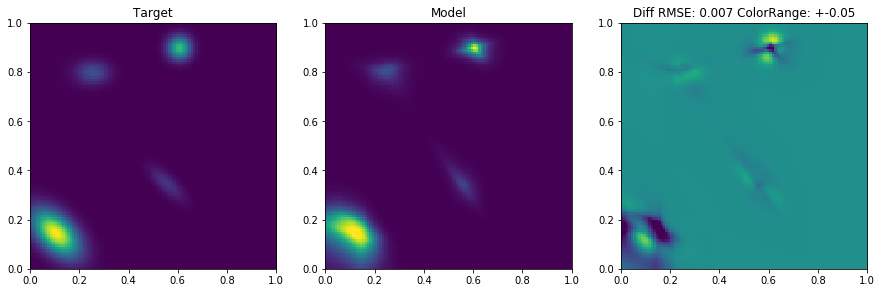

Epoch 007: Loss: 0.017, RMSE: 0.007


KeyboardInterrupt: 

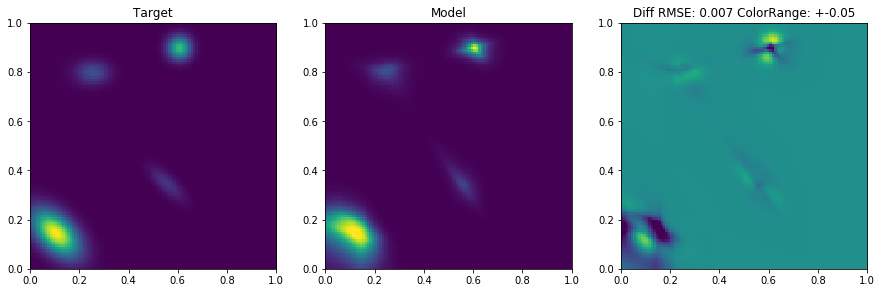

In [74]:
import tqdm
import matplotlib.pyplot as plt
import matplotlib.animation
import numpy as np
from IPython.display import display, clear_output

## Note: Rerunning this cell uses the same model variables

n_step=0
num_epochs = 750

fig, axes = plt.subplots(ncols=3,nrows=1, figsize=(15,5))

axes[0].imshow(p_grid, cmap='viridis', extent=[0,world_size[0],0,world_size[1]],vmin=0, vmax=p_grid.max())
axes[0].set_title('Target')
im_model = axes[1].imshow(p_grid, cmap='viridis', extent=[0,world_size[0],0,world_size[1]],vmin=0, vmax=p_grid.max())
axes[1].set_title('Model')
im_diff = axes[2].imshow(p_grid-p_grid, cmap='viridis', extent=[0,world_size[0],0,world_size[1]],
                         vmin=-.05, vmax=.05)
axes[2].set_title('Diff')

for epoch in range(num_epochs):
    epoch_loss_avg = tfe.metrics.Mean()
    epoch_accuracy = tfe.metrics.Accuracy()

    # Training loop 
    for x, y in tfe.Iterator(train_dataset):
        # Optimize the model
        grads = grad(model, x, y)
        optimizer.apply_gradients(zip(grads, model.variables),
                                  global_step=tf.train.get_or_create_global_step())
        n_step+=1

        # Track progress
        l = loss(model,x,y)
        epoch_loss_avg(l)  # add current batch loss
        # compare predicted label to actual label
        epoch_accuracy(tf.argmax(model(x), axis=1, output_type=tf.int32), y)
 
    # end epoch
    # use model to examine grid fit:
    p_model = []
    for x in tfe.Iterator(grid_dataset):
        p_model.append(tf.nn.softmax(model(x)))
    p_model = np.vstack(p_model)
    p_model = p_model[:,1].reshape(grid.shape[0],grid.shape[1])
    rmse = ((p_model-p_grid)**2).mean()**.5

    #record results
    train_loss_results.append(epoch_loss_avg.result())
    train_accuracy_results.append(epoch_accuracy.result())
    rmse_results.append(rmse)

    if epoch % 1 == 0:
        im_model.set_data(p_model)
        im_diff.set_data(p_grid - p_model)
        axes[2].set_title("Diff RMSE: {:.3f} ColorRange: +-0.05".format(rmse))
        clear_output(wait=True)
        display(fig)    
    
        print("Epoch {:03d}: Loss: {:.3f}, RMSE: {:.3f}".format(epoch,
                                                                epoch_loss_avg.result(),
                                                                rmse))

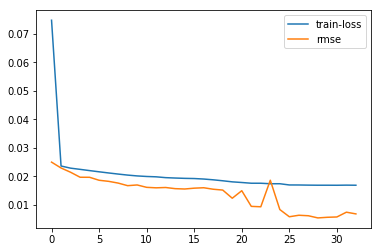

In [75]:
plt.plot(train_loss_results, label='train-loss')
plt.plot(rmse_results, label='rmse')
plt.legend()

Text(0.5,1,'Diff RMSE: 0.007 Range: +-0.079')

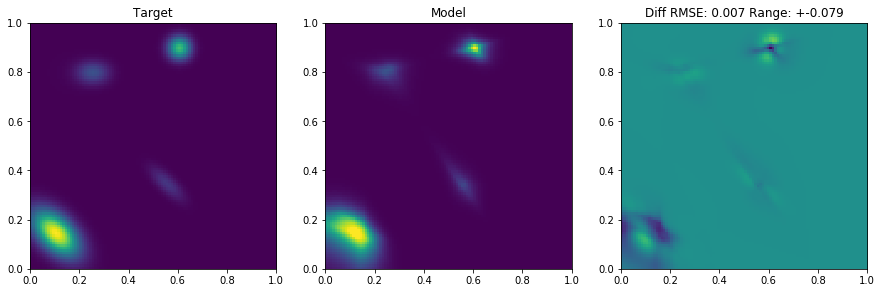

In [77]:
fig, axes = plt.subplots(ncols=3,nrows=1, figsize=(15,5))
axes[0].imshow(p_grid, cmap='viridis', extent=[0,world_size[0],0,world_size[1]],vmin=0, vmax=p_grid.max())
axes[0].set_title('Target')
im_model = axes[1].imshow(p_model, cmap='viridis', extent=[0,world_size[0],0,world_size[1]],vmin=0, vmax=p_grid.max())
axes[1].set_title('Model')
im_diff = axes[2].imshow(p_grid-p_model, cmap='viridis', extent=[0,world_size[0],0,world_size[1]], 
                         vmin=-np.abs(p_grid-p_model).max(),
                         vmax=np.abs(p_grid-p_model).max(),
                        )
rmse = ((p_model-p_grid)**2).mean()**.5
axes[2].set_title("Diff RMSE: {:.3f} Range: +-{:.3f}".format(rmse, np.abs(p_grid-p_model).max()))

In [ ]:
#set up test datset using requests

test_accuracy = tfe.metrics.Accuracy()
grid_list = grid.reshape(grid.shape[0]*grid.shape[1],grid.shape[2])

test_dataset = get_tf_dataset(X_test,y_test,2056)



p_model
for (x, y) in test_dataset:
  prediction = tf.argmax(model(x), axis=1, output_type=tf.int32)
  test_accuracy(prediction, y)


# Try Gradient Boosted Tree

In [ ]:
from sklearn.ensemble import GradientBoostingClassifier
clf = GradientBoostingClassifier(n_estimators=100, learning_rate=1.0,
    max_depth=1, random_state=0).fit(X_train, y_train)
clf.score(X_test, y_test)    

p_predicted = clf.predict_proba(X_test)[:,1]
print(p_predicted[3906],p_test[3906])